# Predicting survivors on Titanic

## Dependencies

In [1]:
# Import Dependencies
%matplotlib inline

from importlib import reload

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Data Imputation
import datawig

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

## Information from the problem description

* There were 2224 people aboard, out of which 1502 died.
* The massive loss of life is mostly due to lack of lifeboats on the ship.
* Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Loading the data

In [2]:
# Import train & test data 
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [3]:
train.head(15)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
# We will progressively copy the training dataframe into separate dataframes
# since it is proferrable to not modify the original dataset in this case
df_train = train.copy()
df_train['Sex'] = df_train['Sex'].astype('category') # Since sex is initially string, make it into a category
df_train['Embarked'] = df_train['Embarked'].astype('category') 
df_train['Survived'] = df_train['Survived'].astype('category') 
df_train['Pclass'] = df_train['Pclass'].astype('category') 
df_nom = pd.DataFrame() # for discretised continuous variables - nominal features
df_ord = pd.DataFrame() # for continuous variables - ordinal features

## Missing values

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


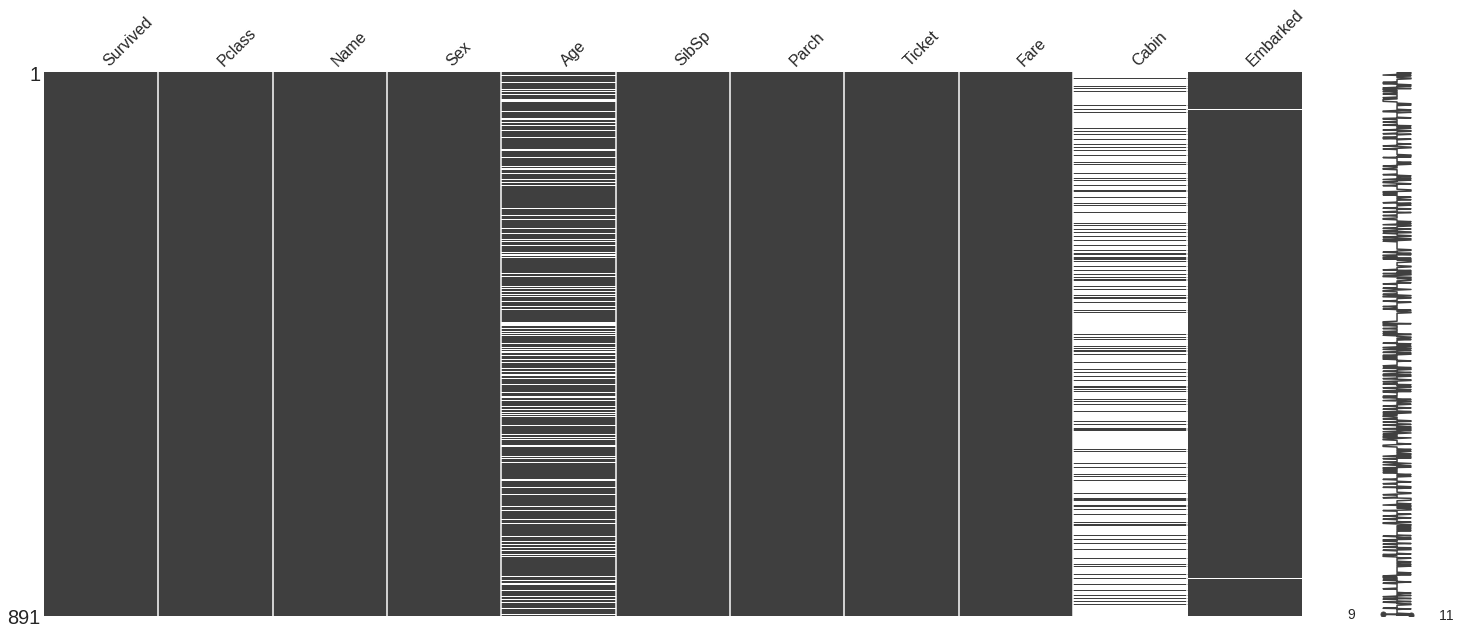

In [6]:
print(train.isnull().sum())
missingno.matrix(train)

Observations:
* Age has almost 20% missing values
* Cabin has 77% missing values
* There are 2 missing values in Embarked. It may be possible to infer them from class and ticket price.

Decisions:
* We may need to have to fill cabin from other sources, or drop it. We will check if its correlated with survival.
* Age will likely have to be filled in, since it is correlated with survival according to the description.
* We may also drop PassengerId, since it is definitely no related to survival.
* Try to impute missing Embarked.

## Duplicates

In [7]:
for _, g in train.groupby("Name"):
    if len(g) > 1:
        print(g)

Observation:
* There seem to be no duplicated names.
* There are duplicated cabins, but that seems to be because cabins are assigned group-wise and multiple people may share the same deck.

## Feature engineering

### Titles

All passangers have titles: True
Selected rare titles: ['Capt.', 'Col.', 'Countess.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 'Rev.', 'Sir.']


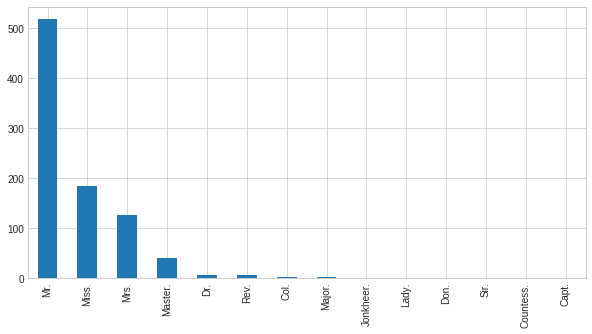

In [8]:
# Get titles from names
def get_title(name):
     return list(filter(lambda x: '.' in x, name.split(' ')))[0]

titles = np.array([get_title(name) for name in train.Name])

# Replace superfluous values
titles[titles == 'Mlle.'] = 'Miss.'
titles[titles == 'Ms.'] = 'Miss.'
titles[titles == 'Mme.'] = 'Mrs.'

# Do all people have titles?
print('All passangers have titles:', len(titles) == len(train))

# Plot histogram of titles
pd.Series(titles).value_counts().plot('bar', figsize=(10,5))

# Add titles and rarity as nominal features
rare = [title for title, count in zip(*np.unique(titles, return_counts=True)) if count < 40]

print('Selected rare titles:', rare)
df_train['Title'] = df_train.apply(lambda r: get_title(r.Name), axis=1).astype('category')
df_train['Rare'] = df_train.apply(lambda r: int(r.Title in rare), axis=1).astype('category')

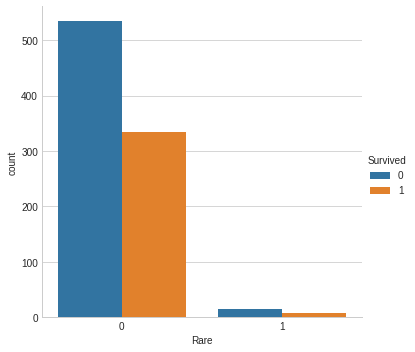

In [9]:
sns.catplot(data=df_train, x='Rare', hue='Survived', kind='count')

Observations:
* All of the names include titles.
* Some of the titles in names are rare.
* Some of the titles are superfluous.
* Bearers of rare titles do not seem to be more likely to survive.

Decisions:
* Do not add title as a feature.

### Cabin

In [10]:
train.Cabin.value_counts()[train.Cabin.value_counts() == 1].index.values

array(['D15', 'C111', 'E77', 'E58', 'C54', 'C90', 'D49', 'C95', 'D28',
       'C32', 'C128', 'A31', 'B38', 'A20', 'A23', 'B78', 'B80', 'C7',
       'C86', 'C82', 'B73', 'C30', 'E36', 'B39', 'B79', 'C104', 'B37',
       'E10', 'B30', 'D47', 'A6', 'B69', 'E68', 'D19', 'E38', 'C47',
       'C85', 'D7', 'A5', 'B102', 'B101', 'C99', 'E50', 'D6', 'D56',
       'B42', 'F G63', 'D50', 'C50', 'D9', 'T', 'A19', 'A24', 'E46',
       'D48', 'D46', 'C46', 'B71', 'C91', 'E34', 'C87', 'E31', 'C101',
       'E17', 'B82 B84', 'C62 C64', 'A14', 'C49', 'E12', 'C110', 'C45',
       'B19', 'B41', 'F E69', 'E63', 'A10', 'A7', 'B86', 'A32', 'D10 D12',
       'A26', 'B4', 'A34', 'A36', 'F38', 'B50', 'C70', 'E40', 'A16',
       'C103', 'B3', 'E49', 'D11', 'C118', 'D45', 'D37', 'C106', 'D21',
       'D30', 'B94', 'C148'], dtype=object)

In [11]:
train[train.Cabin == 'G6']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S


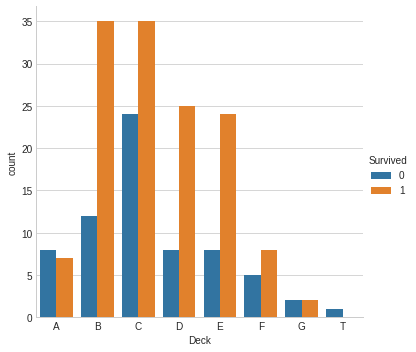

In [12]:
def get_deck(row):
    if row.Cabin is np.NaN:
        return np.NaN
    return str(row.Cabin)[0]

df_train['Deck'] = df_train.apply(lambda r: get_deck(r), axis=1).astype('category')
sns.catplot(data=df_train, x='Deck', hue='Survived', kind='count')

Observations:
* When a group (e.g. family) registered multiple cabins, each passenger seems to have all of the cabins assigned.
* However, some groups have less cabins assigned than the number of persons in group - maybe we can find persons who they are related to and assign them to the same cabin (e.g. based on name). On the other hand, this may be unreliable and just add noise.
* It seems that the lower class sometimes registered multiple persons to a single cabin. Maybe we can quantify that?
* Passengers in cabin A seem slightly more likely to surive (T may be just fluctuation). Maybe we can add a binary feature indicating membership in the class.

Decisions:
* Do not add deck as a feature.

### Family size

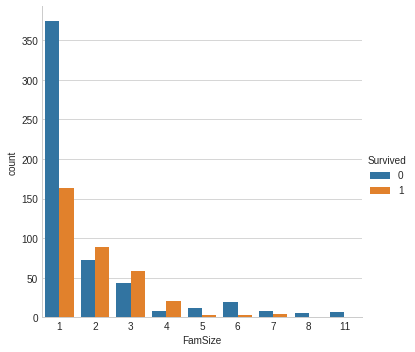

In [13]:
df_train['FamSize'] = train.apply(lambda r: r.SibSp + r.Parch + 1, axis=1)
sns.catplot(data=df_train, x='FamSize', hue='Survived', kind='count')

In [14]:
def get_fam_size(row):
    if row.FamSize == 1:
        return 0
    if 1 < row.FamSize <= 4:
        return 1
    else:
        return 2
    
df_nom['FamSize'] = df_train.apply(lambda r: get_fam_size(r), axis=1).astype('category')

Observation:
* People travelling in families were more likely to survive for family size 2, 3, 4.

Decision:
* Add family size as a categorical (3 categories) feature for the classifier.

## Data imputation

### Imputing missing embarkation

In [15]:
df_train[df_train.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Rare,Deck,FamSize
PassengerId,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.,0,B,1
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.,0,B,1


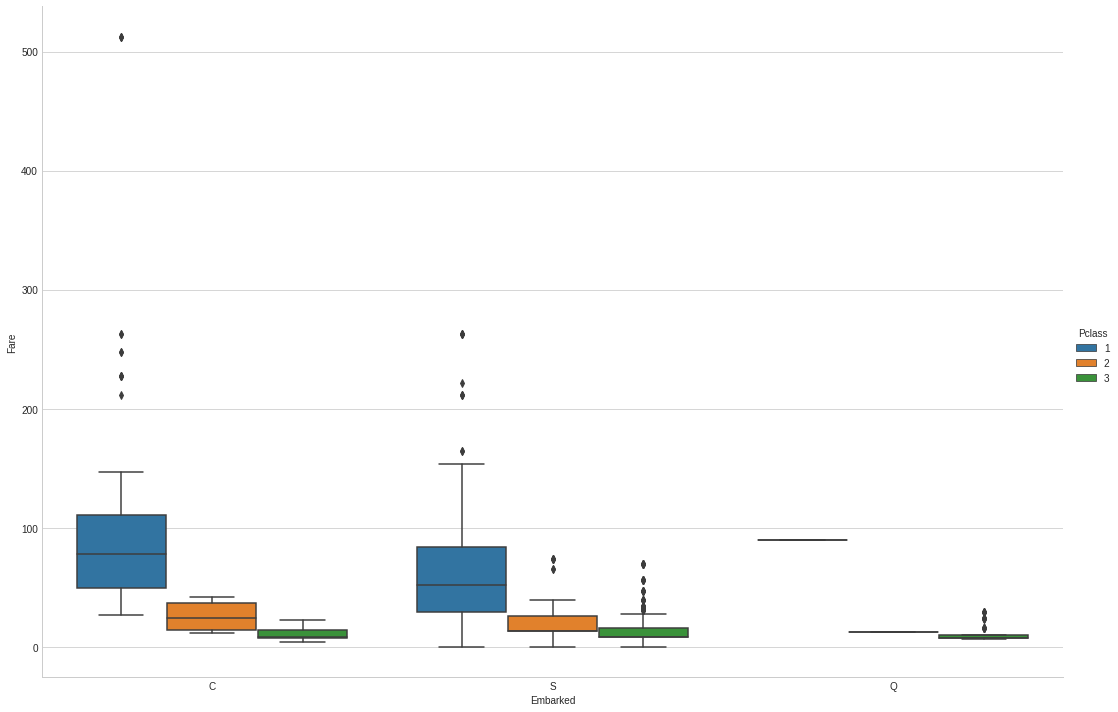

In [16]:
# Plot relationship between Fare, class, and embarked
sns.catplot(
    x='Embarked', y='Fare', hue='Pclass', kind='box', data=train, order=['C', 'S', 'Q'], height= 10, aspect=1.5)

In [17]:
df_train.loc[62, 'Embarked'] = 'S'
df_train.loc[830, 'Embarked'] = 'S'

Observation:
* Median fare for port S corresponds to 80 USD paid by the passengers.

Assumption:
* They embarked from port S.

Decision:
* Impute missing port of embarkation.

### Imputing missing age

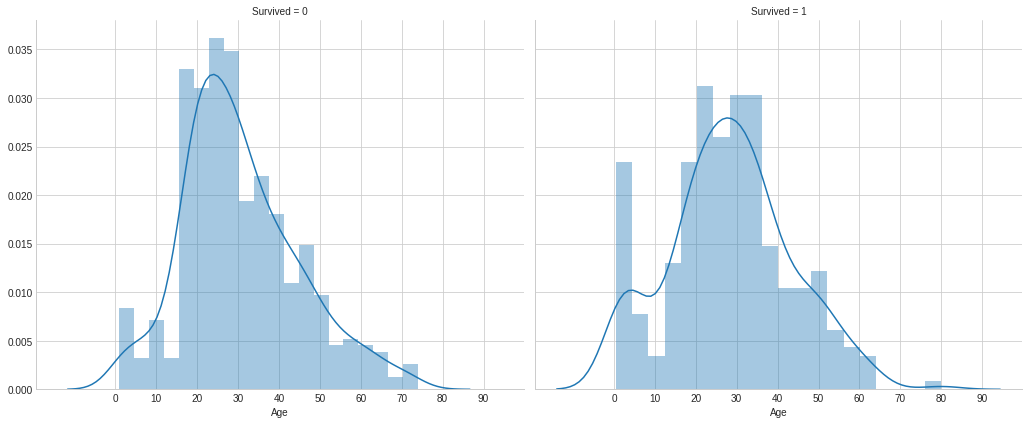

In [18]:
g = sns.FacetGrid(df_train, col='Survived', height=6, aspect=1.2)
g.set(xticks=np.arange(0,len(df_train),10))
g.map(sns.distplot, 'Age', bins=20)

Observation:
* It seems children aged < 5 were much more likely to survive.

Decision:
* Categorize age, put children aged < 5 into a separate category.

In [39]:
df_train.isnull().sum()
df_train.dtypes

Survived    category
Pclass      category
Name          object
Sex         category
Age          float64
SibSp          int64
Parch          int64
Ticket        object
Fare         float64
Cabin         object
Embarked    category
Title       category
Rare        category
Deck        category
FamSize        int64
dtype: object

In [92]:
input_columns = ['Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Fare', 'FamSize', 'Survived']

df_dtwg = pd.get_dummies(df_train[input_columns])

df_dtwg_train, df_dtwg_test = datawig.utils.random_split(df_dtwg, split_ratios=[0.8,0.2])

# Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=df_dtwg.columns, # column(s) containing information about the column we want to impute
    output_column= 'Age', # the column we'd like to impute values for
    # output_path = 'imputer_model' # stores model data and metrics
    )

# Fit an imputer model on the train data
# df_dtwg_train = df_dtwg_train[input_columns].applymap(np.float64)
# df_dtwg_test = df_dtwg_test[input_columns].applymap(np.float64)
imputer.fit(train_df=df_dtwg_train, num_epochs=50)

2019-07-31 20:22:13,539 [INFO]  
========== start: fit model
2019-07-31 20:22:13,541 [WARNING]  Already bound, ignoring bind()
2019-07-31 20:22:13,609 [INFO]  Epoch[0] Batch [0-20]	Speed: 5382.92 samples/sec	cross-entropy=7.428076	Age-accuracy=0.000000
2019-07-31 20:22:13,682 [INFO]  Epoch[0] Train-cross-entropy=0.982071
2019-07-31 20:22:13,686 [INFO]  Epoch[0] Train-Age-accuracy=0.000000
2019-07-31 20:22:13,692 [INFO]  Epoch[0] Time cost=0.145
2019-07-31 20:22:13,702 [INFO]  Saved checkpoint to "age/model-0000.params"
2019-07-31 20:22:13,722 [INFO]  Epoch[0] Validation-cross-entropy=0.487502
2019-07-31 20:22:13,726 [INFO]  Epoch[0] Validation-Age-accuracy=0.000000
2019-07-31 20:22:13,793 [INFO]  Epoch[1] Batch [0-20]	Speed: 5515.49 samples/sec	cross-entropy=0.309331	Age-accuracy=0.000000
2019-07-31 20:22:13,857 [INFO]  Epoch[1] Train-cross-entropy=0.130027
2019-07-31 20:22:13,860 [INFO]  Epoch[1] Train-Age-accuracy=0.000000
2019-07-31 20:22:13,864 [INFO]  Epoch[1] Time cost=0.132
2019

2019-07-31 20:22:15,878 [INFO]  Epoch[14] Validation-cross-entropy=0.011647
2019-07-31 20:22:15,881 [INFO]  Epoch[14] Validation-Age-accuracy=0.000000
2019-07-31 20:22:15,945 [INFO]  Epoch[15] Batch [0-20]	Speed: 5727.48 samples/sec	cross-entropy=0.009290	Age-accuracy=0.000000
2019-07-31 20:22:15,988 [INFO]  Epoch[15] Train-cross-entropy=0.014681
2019-07-31 20:22:15,990 [INFO]  Epoch[15] Train-Age-accuracy=0.000000
2019-07-31 20:22:15,992 [INFO]  Epoch[15] Time cost=0.107
2019-07-31 20:22:15,998 [INFO]  Saved checkpoint to "age/model-0015.params"
2019-07-31 20:22:16,009 [INFO]  Epoch[15] Validation-cross-entropy=0.011957
2019-07-31 20:22:16,011 [INFO]  Epoch[15] Validation-Age-accuracy=0.000000
2019-07-31 20:22:16,065 [INFO]  Epoch[16] Batch [0-20]	Speed: 6891.90 samples/sec	cross-entropy=0.009385	Age-accuracy=0.000000
2019-07-31 20:22:16,101 [INFO]  Epoch[16] Train-cross-entropy=0.014448
2019-07-31 20:22:16,105 [INFO]  Epoch[16] Train-Age-accuracy=0.000000
2019-07-31 20:22:16,110 [INF

In [93]:
from sklearn.metrics import f1_score

# Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_dtwg_test)

imp = imputed[['Age_imputed', 'Age']]
imp

,Age_imputed,Age
PassengerId,,
857,44.208823,45.0
214,29.889136,30.0
466,37.859983,38.0
207,32.057260,32.0
666,31.322828,32.0
886,38.836464,39.0
543,9.974893,11.0
256,28.665146,29.0
413,32.522386,33.0
